<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Model-features" data-toc-modified-id="Model-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model features</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#main-features" data-toc-modified-id="main-features-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>main features</a></span></li></ul></li><li><span><a href="#Genes-and-non-genes-associated-reactions" data-toc-modified-id="Genes-and-non-genes-associated-reactions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Genes and non-genes associated reactions</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-rxns-among-different-pathways" data-toc-modified-id="Distribution-of-rxns-among-different-pathways-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Distribution of rxns among different pathways</a></span></li><li><span><a href="#Distribution-of-rxns-among-different-compartments" data-toc-modified-id="Distribution-of-rxns-among-different-compartments-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Distribution of rxns among different compartments</a></span></li></ul></li></ul></li></ul></div>

In [2]:
#%matplotlib inline
import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import reduce
import glob
import os
import cobra
import re
from jupyterthemes import jtplot
from tqdm import tqdm
from brokenaxes import brokenaxes
#import mca
pd.options.mode.chained_assignment = None
jtplot.style(theme='grade3', grid=False)

# Functions

In [3]:
# FUNCTION compare rxns, mets, and genes of two models
def compare_two_models(model1, model2):
    df_rxns_m1=get_rxns_stat_from_model(model1)
    df_rxns_m2=get_rxns_stat_from_model(model2)
    #compare rxns
    df_rxns_m1_temp = df_rxns_m1.drop_duplicates(subset='rxns', 
                                                 keep='first').reset_index(drop=True)
    df_rxns_m1_temp['status_model1'] = 'present'
    df_rxns_m1_temp= df_rxns_m1_temp[['rxns', 'status_model1']]
    df_rxns_m1_temp.rxns =df_rxns_m1_temp.rxns.astype('str')
    df_rxns_m2_temp = df_rxns_m2.drop_duplicates(subset='rxns', 
                                                 keep='first').reset_index(drop=True)
    df_rxns_m2_temp['status_model2'] = 'present'
    df_rxns_m2_temp= df_rxns_m2_temp[['rxns', 'status_model2']]
    df_rxns_m2_temp.rxns =df_rxns_m2_temp.rxns.astype('str')
    df_rxns_compare = pd.merge(df_rxns_m1_temp, df_rxns_m2_temp, on='rxns', how='outer')
    df_rxns_compare=df_rxns_compare[df_rxns_compare.status_model1.isna() | 
                    df_rxns_compare.status_model2.isna()].reset_index(drop=True)
    #print(df_rxns_compare.to_string())
    #compare mets
    df_rxns_m1_temp = df_rxns_m1.drop_duplicates(subset='mets', 
                                                 keep='first').reset_index(drop=True)
    df_rxns_m1_temp['status_model1'] = 'present'
    df_rxns_m1_temp= df_rxns_m1_temp[['mets', 'status_model1']]
    df_rxns_m1_temp.mets =df_rxns_m1_temp.mets.astype('str')
    df_rxns_m2_temp = df_rxns_m2.drop_duplicates(subset='mets', 
                                                 keep='first').reset_index(drop=True)
    df_rxns_m2_temp['status_model2'] = 'present'
    df_rxns_m2_temp= df_rxns_m2_temp[['mets', 'status_model2']]
    df_rxns_m2_temp.mets =df_rxns_m2_temp.mets.astype('str')
    df_mets_compare = pd.merge(df_rxns_m1_temp, df_rxns_m2_temp, on='mets', how='outer')
    df_mets_compare=df_mets_compare[df_mets_compare.status_model1.isna() | 
                    df_mets_compare.status_model2.isna()].reset_index(drop=True)
    #compare genes
    df_genes_m1 =get_only_genes_stat_from_model(model1)
    df_genes_m2 =get_only_genes_stat_from_model(model2)
    df_genes_m1_temp = df_genes_m1.drop_duplicates(subset='genes', 
                                                 keep='first').reset_index(drop=True)
    df_genes_m1_temp['status_model1'] = 'present'
    df_genes_m1_temp= df_genes_m1_temp[['genes', 'status_model1']]
    df_genes_m1_temp.genes =df_genes_m1_temp.genes.astype('str')
    df_genes_m2_temp = df_genes_m2.drop_duplicates(subset='genes', 
                                                 keep='first').reset_index(drop=True)
    df_genes_m2_temp['status_model2'] = 'present'
    df_genes_m2_temp= df_genes_m2_temp[['genes', 'status_model2']]
    df_genes_m2_temp.genes =df_genes_m2_temp.genes.astype('str')
    df_genes_compare = pd.merge(df_genes_m1_temp, df_genes_m2_temp, on='genes', how='outer')
    df_genes_compare=df_genes_compare[df_genes_compare.status_model1.isna() | 
                    df_genes_compare.status_model2.isna()].reset_index(drop=True)
    #print(df_mets_compare.to_string())
    
    return df_rxns_compare, df_mets_compare, df_genes_compare

In [4]:
# FUNCTION get reactions and associated metabolites and gene reaction rules
def get_rxns_stat_from_model(model):    
    rxns=[]
    for i, rxn in enumerate(model.reactions):
        for j, met in enumerate(rxn.metabolites):
            rxns.append((rxn.id, met.id, rxn.gene_reaction_rule))
    df_rxns=pd.DataFrame(rxns, columns=['rxns', 'mets', 'gr'])
    return df_rxns

In [5]:
# FUNCTION get reactions and associated gpr, equation, subsystems and compartments
# NO METABOLITES
def get_only_rxns_stat_from_model(model):    
    rxns=[]
    for i, rxn in enumerate(model.reactions):
        rxns.append((rxn.id, rxn.name, rxn.gene_reaction_rule, rxn.reaction, rxn.subsystem, rxn.compartments))
    df_rxns=pd.DataFrame(rxns, columns=['rxns', 'rxn_name', 'gr', 'equation', 'subs', 'comp'])
    return df_rxns

In [6]:
# FUNCTION get metabolites and their names
def get_only_mets_stat_from_model(model):    
    mets=[]
    for i, met in enumerate(model.metabolites):
        mets.append((met.id, met.name, met.formula, met.compartment))
    df_mets=pd.DataFrame(mets, columns=['mets', 'met_name', 'met_formula', 'met_conpartment'])
    return df_mets

In [7]:
# extract only genes
def get_only_genes_stat_from_model(model):
    genes = []
    for i, gene in enumerate(model.genes):
        genes.append(gene.id)
    df_genes = pd.DataFrame(genes, columns=['genes'])
    return df_genes

# Model features

In [8]:
# load model
model = cobra.io.load_json_model('iMK1961.json')

### main features

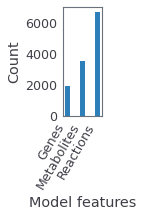

In [10]:
# plot main features
width = 0.35     
    
items = ['Genes', 'Metabolites', 'Reactions']
values = [len(model.genes),
            len(model.metabolites),
            len(model.reactions)]
fig, ax = plt.subplots(figsize=(.7,2))
ax.bar(items, values, width, 
       color= ['#2c7fb8'])
ax.set_xlabel('Model features')
ax.set_ylabel('Count')
plt.xticks(rotation=60, ha='right')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('model_main_features.svg')
plt.show()

## Genes and non-genes associated reactions

In [11]:
rxns = []
for i, rxn in enumerate(model.reactions):
    rxns.append((rxn.id, rxn.gene_reaction_rule))
df_rxns = pd.DataFrame(rxns, columns=['rxn', 'gpr'])
rxn_no_gene = len(df_rxns[df_rxns.gpr ==''])
rxn_gene =len(model.reactions) - len(df_rxns[df_rxns.gpr ==''])

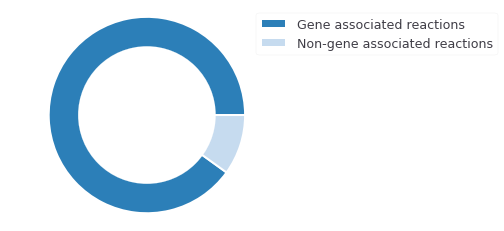

In [13]:
# plot gene and non-gene associated rxns (Pie chart)
plt.figure(figsize=(5,4))
values = [rxn_gene, rxn_no_gene]
items = ['Gene associated reactions', 'Non-gene associated reactions']
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(values, 
        wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=['#2c7fb8','#c6dbef'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('equal')
plt.legend(items, loc='best', bbox_to_anchor=(0.87, 0, 0.5, 1))
#plt.savefig('rxns_genes_nongenes_pie.svg')

### Distribution of rxns among different pathways

In [22]:
rxns = []
for i, rxn in enumerate(model.reactions):
    rxns.append((rxn.id, rxn.gene_reaction_rule, rxn.subsystem, rxn.compartments))
df_rxns = pd.DataFrame(rxns, columns=['rxn', 'gpr', 'subs', 'comp'])

ind_temp =list(df_rxns[(df_rxns.subs =='') &
        (df_rxns.rxn.str.contains('EX_|DM_'))].index)
df_rxns.subs.iloc[ind_temp] = 'Extracellular exchange'

# LOAD PATHWAY DICTIONARY
pathw_path = 'pathways_manual.txt'
df_path = pd.read_csv(pathw_path, sep='\t', header=None)
df_path.columns = ['subs', 'temp', 'path']
df_path =df_path.drop(labels='temp', axis=1)

df_subs_path = pd.merge(df_rxns, df_path, on='subs', how='left')

def refine_path(source, target):    
    indx_temp = df_subs_path[df_subs_path.path == source].path.index
    df_subs_path.path.iloc[indx_temp] = target
    return df_subs_path

df_subs_path = refine_path('Biomass', 'Not specified')
df_subs_path = refine_path('Not specified' , 'Unassigned')

df_path_counts_all = df_subs_path.path.value_counts().to_frame().reset_index()
df_path_counts_all = df_path_counts_all.rename(columns={'index':'path_name'})

df_path_counts_gene = df_subs_path[df_subs_path.gpr != ''].path.value_counts().to_frame().reset_index()

df_path_counts_nogene = df_subs_path[df_subs_path.gpr == ''].path.value_counts().to_frame().reset_index()

df_path_counts = pd.merge(df_path_counts_gene, df_path_counts_nogene, on='index', 
                 how='left', suffixes=('_gene', '_nogene')).fillna(0.0)

df_path_counts = df_path_counts.rename(columns={'index':'path_name'})

df_path_counts = pd.merge(df_path_counts_all, df_path_counts, on='path_name', how='left')

In [23]:
df_path_counts

,path_name,path,path_gene,path_nogene
0,Lipid metabolism,6346,6306,40.0
1,Transport,801,292,509.0
2,Amino acid metabolism,513,495,18.0
3,Exchange,485,45,440.0
4,Carbohydrate metabolism,373,358,15.0
5,Nucleotide metabolism,312,296,16.0
6,Metabolism of cofactors and vitamins,241,239,2.0
7,Energy metabolism,150,130,20.0
8,Metabolism of terpenoids and polyketides,56,56,0.0
9,Unassigned,44,37,7.0


/home/manish/anaconda2/envs/rstudio/lib/python3.7/site-packages/brokenaxes.py:294 UserWarning: FixedFormatter should only be used together with FixedLocator


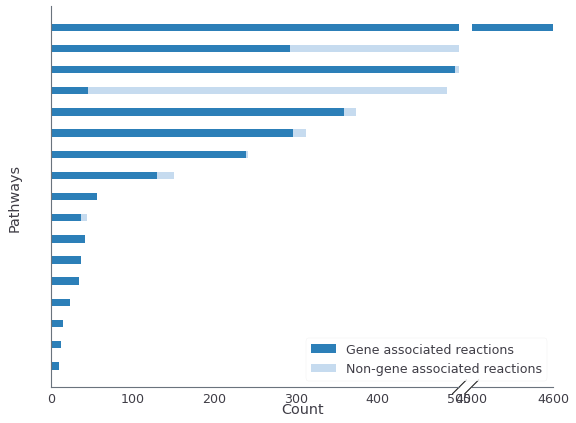

In [24]:
labels = list(df_path_counts.path_name)
path_gene = list(df_path_counts.path_gene)
path_nogene = list(df_path_counts.path_nogene)
plt.figure(figsize=(9,7))
width = 0.35       # the width of the bars: can also be len(x) sequence
bax = brokenaxes(xlims=((0, 500), (4500, 4600)), 
                 wspace=0.05
                 )
bax.barh(labels, path_gene, width, label='Gene associated reactions', color='#2c7fb8')
bax.barh(labels, path_nogene, width, left=path_gene,
       label='Non-gene associated reactions',color ='#c6dbef')
bax.set_yticks(np.arange(len(labels)))
#bax.set_yticklabels(labels)
bax.set_yticklabels([''])
bax.invert_yaxis()

bax.set_ylabel('Pathways')
bax.set_xlabel('Count')

bax.legend(loc= 'lower right')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('rxns_genes_nongenes_path_bar.svg')
plt.show()

### Distribution of rxns among different compartments

In [27]:
df_rxns = df_subs_path.copy()
df_rxns.comp = df_rxns.comp.astype('str')
#df_rxns.head()

In [28]:
def count_rxns_compartment(data):
    #COUNT REACTIONS IN COMPARTMENTS
    df_rxns_all = data.groupby(['comp'])['rxn'].count().to_frame(name ='rxn_count').reset_index()

    df_rxns_all.comp = df_rxns_all.comp.str.replace('{', '')
    df_rxns_all.comp = df_rxns_all.comp.str.replace('}', '')

    # COUNT REACTIONS IN EACH COMPARTMENT IN CASE THE REACTION IS INVOLVED IN MORE THAN 
    # ONE COMPARTMENT INCLUDING TRANSPORT REACTIONS
    df_rxns_all_temp = df_rxns_all.comp.str.split(pat = ",", expand=True)
    if len(df_rxns_all_temp.columns) == 4:
        df_rxns_all_temp.columns = ['comp1','comp2','comp3','comp4']
    elif len(df_rxns_all_temp.columns) == 3:
        df_rxns_all_temp.columns = ['comp1','comp2','comp3']
    elif len(df_rxns_all_temp.columns) == 2:
        df_rxns_all_temp.columns = ['comp1','comp2']
    elif len(df_rxns_all_temp.columns) == 1:
        df_rxns_all_temp.columns = ['comp1']

    df_rxns_all_temp['rxn_count'] = df_rxns_all.rxn_count

    comp_temp = []
    for i, col in enumerate(df_rxns_all_temp.columns):
        if (col != 'comp1') & (col !='rxn_count'):
            indx_temp = list(df_rxns_all_temp[df_rxns_all_temp[col].notna()].index)
            for j, ind in enumerate(indx_temp):
                comp_temp.append((df_rxns_all_temp[col].iloc[ind], 
                              df_rxns_all_temp['rxn_count'].iloc[ind]))
    df_extr_comp = pd.DataFrame(comp_temp, columns=['comp', 'rxn_count'])

    df_rxns_all_temp1 = df_rxns_all_temp[['comp1', 'rxn_count']]
    df_rxns_all_temp1 = df_rxns_all_temp1.rename(columns={'comp1':'comp'})

    df_rxns_all_temp1 = pd.concat([df_rxns_all_temp1, df_extr_comp], axis=0).reset_index(drop=True)

    df_rxns_all_temp1.comp = df_rxns_all_temp1.comp.astype('str')
    df_rxns_all_temp1.comp = df_rxns_all_temp1.comp.str.replace(' ', '')

    #RECOUNT THE REACTINS IN COMPARTMENTS
    df_comp = df_rxns_all_temp1.groupby(['comp']).sum().reset_index()

    for i, comp in enumerate(df_comp.comp):
        if comp == "'c'":
            df_comp.comp.iloc[i] = 'Cytosol'
        elif comp == "'e'":
            df_comp.comp.iloc[i] = 'Extracellular space'
        elif comp == "'p'":
            df_comp.comp.iloc[i] = 'Periplasm'
        elif comp == "'h'":
            df_comp.comp.iloc[i] = 'Chloroplast'
        elif comp == "'m'":
            df_comp.comp.iloc[i] = 'Mitochondria'
        elif comp == "'x'":
            df_comp.comp.iloc[i] = 'Peroxisome/glyoxysome'
        elif comp == "'u'":
            df_comp.comp.iloc[i] = 'Thylakoid'
    return df_comp
        

In [29]:
# COUNT RXNS IN COMPARTMENTS BASED ON GENE AND NON-GENE ASSOCIATED RXNS
df_rxns_gene = df_rxns[df_rxns.gpr != ''].reset_index(drop=True)
df_rxns__nogene = df_rxns[df_rxns.gpr == ''].reset_index(drop=True)
df_comp_all = count_rxns_compartment(data=df_rxns)
df_comp_gene = count_rxns_compartment(data=df_rxns_gene)
df_comp_nogene = count_rxns_compartment(data=df_rxns__nogene)
df_comp = pd.merge(df_comp_all, df_comp_gene, on='comp', how='left', suffixes=('_all', '_gene'))
df_comp = pd.merge(df_comp, df_comp_nogene, on='comp', how='left')
df_comp = df_comp.rename(columns={'rxn_count':'rxn_count_nogene'})
df_comp =df_comp.sort_values(by='rxn_count_all', ascending=False)

/home/manish/anaconda2/envs/rstudio/lib/python3.7/site-packages/ipykernel_launcher.py:5 FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/home/manish/anaconda2/envs/rstudio/lib/python3.7/site-packages/ipykernel_launcher.py:6 FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [30]:
df_comp

,comp,rxn_count_all,rxn_count_gene,rxn_count_nogene
0,Cytosol,7312,6766,546
2,Chloroplast,1176,983,193
3,Mitochondria,840,693,147
1,Extracellular space,706,126,580
4,Periplasm,277,36,241
6,Peroxisome/glyoxysome,202,186,16
5,Thylakoid,46,19,27


/home/manish/anaconda2/envs/rstudio/lib/python3.7/site-packages/brokenaxes.py:294 UserWarning: FixedFormatter should only be used together with FixedLocator


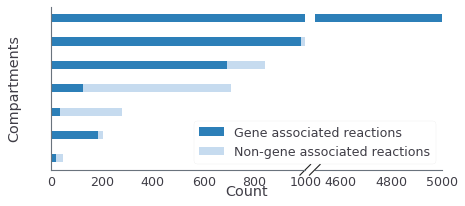

In [31]:
labels = list(df_comp.comp)
comp_gene = list(df_comp.rxn_count_gene)
comp_nogene = list(df_comp.rxn_count_nogene)
plt.figure(figsize=(7,3))
width = 0.35       # the width of the bars: can also be len(x) sequence
bax = brokenaxes(xlims=((0, 1000), (4500, 5000)), 
                 #hspace=.05,
                 wspace=0.05
                 )

bax.barh(labels, comp_gene, width, label='Gene associated reactions', color='#2c7fb8')
bax.barh(labels, comp_nogene, width, left=comp_gene,
       label='Non-gene associated reactions', color ='#c6dbef')
bax.set_yticks(np.arange(len(labels)))
#bax.set_yticklabels(labels)
bax.set_yticklabels([''])
bax.invert_yaxis()

bax.set_ylabel('Compartments')
bax.set_xlabel('Count')
#bax.set_title('Scores by group and gender')
bax.legend(loc= 'lower right')
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('rxns_genes_nongenes_comp_bar.svg')
plt.show()